In [1]:
import os
import sys
import re
import shutil
import time
import pickle
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

COLORS = ["darkorange","royalblue","slategrey"]

In [4]:
# import common functions and variables
from CapstoneCommon import *

In [5]:
cwd = os.getcwd()
print(cwd)

/home/alain/Desktop/ai-workflow-capstone-master


In [7]:
run_start = time.time() 

# read all the training data
data_dir = os.path.join(cwd,"data","cs-train")
print(data_dir)
print("...fetching data")

# load all json formatted invoice files into a dataframe mydf
mydf = fetch_data(data_dir)

# read the invoice data and create one file per country
# use clean=True when you want to re-create the files
ts_all = fetch_ts(data_dir,clean=False)

m, s = divmod(time.time()-run_start,60)
h, m = divmod(m, 60)
print("load time:", "%d:%02d:%02d"%(h, m, s))

for key,item in ts_all.items():
    print(key,item.shape)

/home/alain/Desktop/ai-workflow-capstone-master/data/cs-train
...fetching data
... loading ts data from files
load time: 0:00:12
all (607, 7)
france (607, 7)
norway (577, 7)
united_kingdom (607, 7)
netherlands (607, 7)
portugal (607, 7)
germany (607, 7)
spain (607, 7)
eire (607, 7)
hong_kong (426, 7)
singapore (456, 7)


## explore invoice data

In [8]:
mydf.head()

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,16393.0,28,489536,11,2.25,21581,4,2017,2017-11-28
1,United Kingdom,13085.0,28,489434,11,6.75,79323P,12,2017,2017-11-28
2,United Kingdom,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
3,United Kingdom,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28
4,United Kingdom,13085.0,28,489434,11,1.25,21232,5,2017,2017-11-28


In [18]:
mydf.describe(include="all")

<ipython-input-18-5000d1d67922>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  mydf.describe(include="all")


,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
count,815011,625249.000000,815011.000000,815011,815011.000000,815011.000000,815011,815011.000000,815011.000000,815011
unique,43,NaN,NaN,42646,NaN,NaN,5007,NaN,NaN,495
top,United Kingdom,NaN,NaN,537434,NaN,NaN,85123A,NaN,NaN,2018-12-03 00:00:00
freq,751228,NaN,NaN,1350,NaN,NaN,5017,NaN,NaN,7756
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-28 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-31 00:00:00
mean,NaN,15333.415068,15.064819,NaN,6.592718,4.802631,NaN,5.231106,2018.247654,NaN
std,NaN,1698.360788,8.788845,NaN,3.598781,135.058707,NaN,5.109982,0.545261,NaN
min,NaN,12346.000000,1.000000,NaN,1.000000,-53594.360000,NaN,0.000000,2017.000000,NaN
25%,NaN,13956.000000,7.000000,NaN,3.000000,1.250000,NaN,1.000000,2018.000000,NaN


In [18]:
# check total invoice value per country
pd.pivot_table(mydf, values = 'price', index=['country'],aggfunc=np.sum).reset_index()

,country,price
0,Australia,6.872630e+03
1,Austria,3.390890e+03
2,Bahrain,4.394900e+02
3,Belgium,1.119061e+04
4,Bermuda,8.470000e+01
5,Brazil,2.563100e+02
6,Canada,1.053100e+03
7,Channel Islands,7.610120e+03
8,Cyprus,4.976300e+03
9,Czech Republic,3.183000e+01


In [20]:
pd.pivot_table(mydf, values = 'price', index=['invoice_date']).reset_index()

,invoice_date,price
0,2017-11-28,4.483568
1,2017-11-29,4.092756
2,2017-11-30,4.427132
3,2017-12-01,3.785572
4,2017-12-02,3.590199
...,...,...
490,2019-07-26,3.211264
491,2019-07-28,2.478568
492,2019-07-29,3.645450
493,2019-07-30,11.961110


In [21]:
mydf.groupby(["country"]).sum()

,customer_id,day,month,price,times_viewed,year
country,,,,,,
Australia,1.927165e+07,25288,9595,6.872630e+03,13774,3114601
Austria,8.969334e+06,12578,5063,3.390890e+03,6257,1451077
Bahrain,7.288970e+05,2546,600,4.394900e+02,969,254286
Belgium,2.698339e+07,34031,12907,1.119061e+04,17733,4371985
Bermuda,0.000000e+00,510,102,8.470000e+01,361,68612
Brazil,1.199170e+06,1500,686,2.563100e+02,433,189724
Canada,3.711293e+06,2993,1720,1.053100e+03,2122,450160
Channel Islands,1.906329e+07,21300,8653,7.610120e+03,9673,2597487
Cyprus,1.127679e+07,12496,6055,4.976300e+03,5783,1830400


In [22]:
len(mydf.invoice_date.unique())

495

In [23]:
mydf.nunique(0)

country            43
customer_id      5225
day                31
invoice         42646
month              12
price            2415
stream_id        5007
times_viewed       25
year                3
invoice_date      495
dtype: int64

In [22]:
# check for null values
for column in mydf.columns:
    print(column,mydf[column].isnull().count())


country 815011
customer_id 815011
day 815011
invoice 815011
month 815011
price 815011
stream_id 815011
times_viewed 815011
year 815011
invoice_date 815011


In [20]:
# Evaluating for Missing Data
missing_data = mydf.isnull()
missing_data.head(5)

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False


In [21]:
# Count missing values in each column
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts(), "\n") 

country
False    815011
Name: country, dtype: int64 

customer_id
False    625249
True     189762
Name: customer_id, dtype: int64 

day
False    815011
Name: day, dtype: int64 

invoice
False    815011
Name: invoice, dtype: int64 

month
False    815011
Name: month, dtype: int64 

price
False    815011
Name: price, dtype: int64 

stream_id
False    815011
Name: stream_id, dtype: int64 

times_viewed
False    815011
Name: times_viewed, dtype: int64 

year
False    815011
Name: year, dtype: int64 

invoice_date
False    815011
Name: invoice_date, dtype: int64 



<AxesSubplot:xlabel='month'>

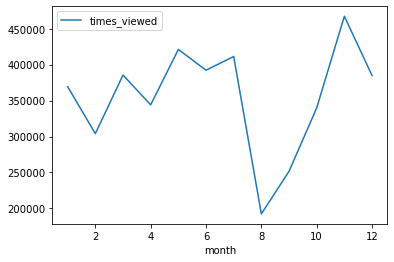

In [25]:
# check graphically the views per month
pd.pivot_table(mydf, values = 'times_viewed', index=['month'],aggfunc=np.sum).reset_index().plot("month","times_viewed")

## generate and explore time-series data
given the original DataFrame (fetch_data())
return a numerically indexed time-series DataFrame
by aggregating over each day


In [17]:
myts = convert_to_ts(mydf, country=None)
myts.head()

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue
0,2017-11-01,0,0,0,0,2017-11,0.0
1,2017-11-02,0,0,0,0,2017-11,0.0
2,2017-11-03,0,0,0,0,2017-11,0.0
3,2017-11-04,0,0,0,0,2017-11,0.0
4,2017-11-05,0,0,0,0,2017-11,0.0


In [10]:
myts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             607 non-null    datetime64[ns]
 1   purchases        607 non-null    int64         
 2   unique_invoices  607 non-null    int64         
 3   unique_streams   607 non-null    int64         
 4   total_views      607 non-null    int64         
 5   year_month       607 non-null    object        
 6   revenue          607 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 33.3+ KB


In [11]:
# give an overvirew of the timestamp series data
myts.describe()

,purchases,unique_invoices,unique_streams,total_views,revenue
count,607.000000,607.000000,607.000000,607.000000,607.000000
mean,1273.464580,66.919275,658.074135,6651.255354,6131.698394
std,1015.758467,47.871442,411.048951,4990.636140,10395.054288
min,0.000000,0.000000,0.000000,0.000000,-44990.049000
25%,634.500000,27.000000,435.500000,2681.500000,1805.780000
50%,1293.000000,70.000000,764.000000,7080.000000,4778.020000
75%,1752.500000,98.000000,934.000000,9368.000000,7640.235000
max,7756.000000,219.000000,1596.000000,29374.000000,170304.180000


In [12]:
# what are the maximum values
myts.max(0)

date               2019-06-30 00:00:00
purchases                         7756
unique_invoices                    219
unique_streams                    1596
total_views                      29374
year_month                     2019-06
revenue                         170304
dtype: object

In [16]:
# what are the minimum values
myts.min(0)

date               2017-11-01 00:00:00
purchases                            0
unique_invoices                      0
unique_streams                       0
total_views                          0
year_month                     2017-11
revenue                         -44990
dtype: object

In [14]:
# how many unique values
myts.nunique(0)

date               607
purchases          427
unique_invoices    141
unique_streams     358
total_views        460
year_month          20
revenue            469
dtype: int64

In [15]:
grouped = myts.groupby("date")
grouped.size()
# we have 607 different dates, each having one record
# dates vary between 2017-11-01 00:00:00 and 2019-06-30 00:00:00

date
2017-11-01    1
2017-11-02    1
2017-11-03    1
2017-11-04    1
2017-11-05    1
             ..
2019-06-26    1
2019-06-27    1
2019-06-28    1
2019-06-29    1
2019-06-30    1
Length: 607, dtype: int64

In [24]:
myts.nunique(0)

date               607
purchases          427
unique_invoices    141
unique_streams     358
total_views        460
year_month          20
revenue            469
dtype: int64

<AxesSubplot:xlabel='year_month'>

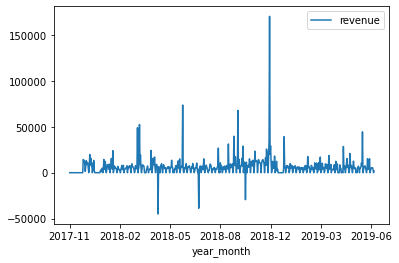

In [26]:
# plot the revenue per month
myts.plot("year_month","revenue")

## DO a frequency analysis

In [58]:
import datetime
import numpy as np
import scipy as sp
import scipy.fftpack
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Now, we get the list of dates and the list of corresponding temperatures. The unit is in tenths of a degree, and we get the average value between the minimal and maximal temperature, which explains why we divide by 20.

date = myts.year_month
feat = myts.revenue
N = len(feat)

Text(0, 0.5, 'revenue')

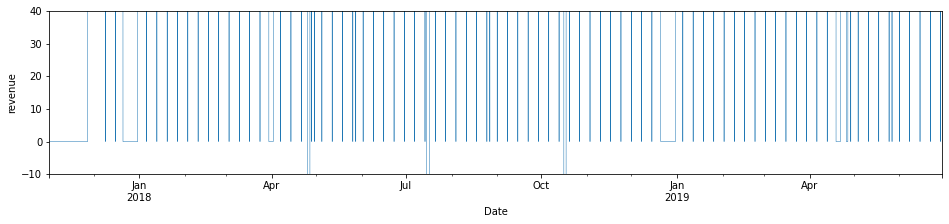

In [59]:
#Let's take a look at the evolution of the Revenue

fig, ax = plt.subplots(1, 1, figsize=(16, 3))
feat.plot(ax=ax, lw=.5)
ax.set_ylim(-10, 40)
ax.set_xlabel('Date')
ax.set_ylabel('revenue')

In [34]:
#We now compute the Fourier transform and the spectral density of the signal. The first step is to compute the FFT of the signal using the fft() function:

feat_fft = sp.fftpack.fft(feat)

#Once the FFT has been obtained, we need to take the square of its absolute value in order to get the power spectral density (PSD):

feat_psd = np.abs(feat_fft) ** 2

#The next step is to get the frequencies corresponding to the values of the PSD. The fftfreq() utility function does just that. It takes the length of the PSD vector as input as well as the frequency unit. Here, we choose an annual unit: a frequency of 1 corresponds to 1 year (365 days). We provide 1/365 because the original unit is in days:

fftfreq = sp.fftpack.fftfreq(len(feat_psd), 1. / 7)

#The fftfreq() function returns positive and negative frequencies. We are only interested in positive frequencies here, as we have a real signal:

i = fftfreq > 0


Text(0, 0.5, 'PSD (dB)')

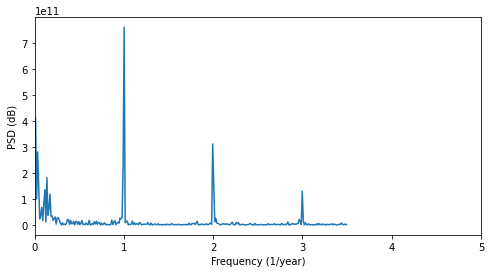

In [35]:
#We now plot the power spectral density of our signal, as a function of the frequency (in unit of 1/year). We choose a logarithmic scale for the y axis (decibels):

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(fftfreq[i], feat_psd[i])
ax.set_xlim(0, 5)
ax.set_xlabel('Frequency (1/week)')
ax.set_ylabel('PSD (dB)')

#we see a clearly weekly frequency

Feature Engineering

In [36]:
#We will now go ahead and set this column as the index for the dataframe using the set_index() call.
myts = myts.set_index('date')

In [27]:
# At times, it would be essential to extract the month, day of the week, date, etc for each timestamp (i.e. each row of our data). Since we already have the indices set in the DateTime format, extracting these elements become super easy:
# Extract the year, month, date separately using the index set
myts['Year'] = myts.index.year
myts['Month'] = myts.index.month
myts['Week'] = myts.index.week
myts['Weekday_Name'] = myts.index.dayofweek
myts.head(10)

AttributeError: 'RangeIndex' object has no attribute 'year'

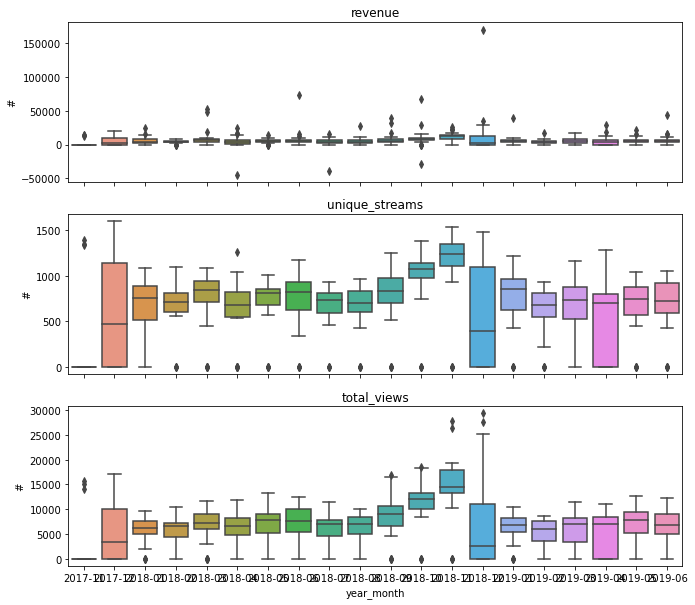

In [24]:
#These additional features can also be useful for exploratory analysis of your dataset. For instance, we can plot the median power consumption for each month.
import seaborn as sns
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['revenue', 'unique_streams', 'total_views'], axes):
    sns.boxplot(data=myts, x='year_month', y=name, ax=ax)
    ax.set_ylabel('#')
    ax.set_title(name)
    # Keep the x-axis label for only the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')

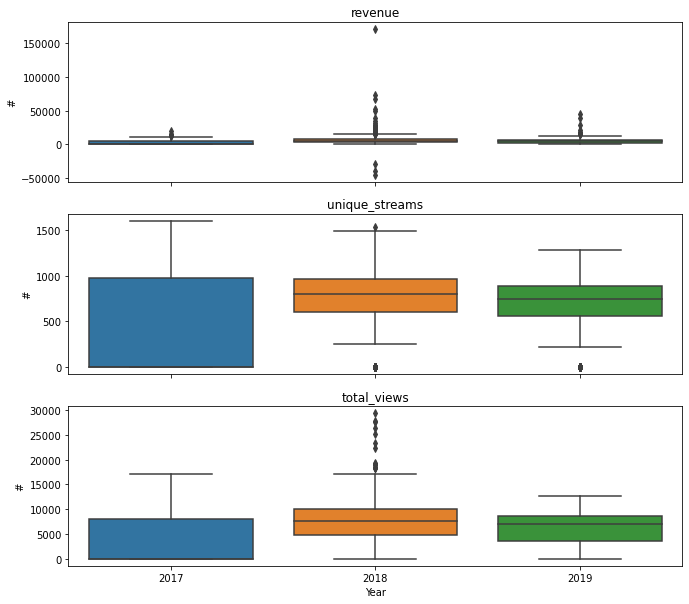

In [41]:
#Same analysis but per year
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['revenue', 'unique_streams', 'total_views'], axes):
    sns.boxplot(data=myts, x='Year', y=name, ax=ax)
    ax.set_ylabel('#')
    ax.set_title(name)
    # Keep the x-axis label for only the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')

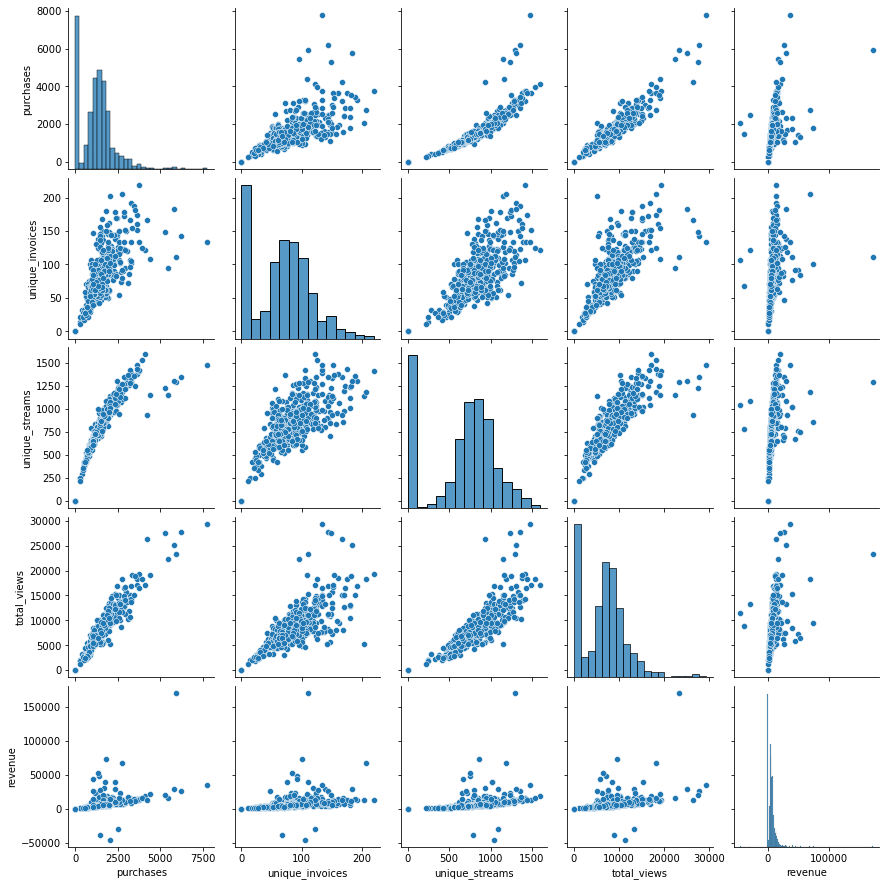

In [26]:
sns.pairplot(data=myts)